In [1]:
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from Utils.rl_glue import RLGlue
from tqdm import tqdm
import pickle
import gym
import sys
from Utils import envVisual
from Agents import agent
from Agents.QLearningAgent import QLearningAgent
from Agents.ExpectedSarsaAgent import ExpectedSarsaAgent
from Environments import gridworld_env

In [2]:
def visualize_state_visits(state_visits, title):
    grid_size = int(np.sqrt(len(state_visits)))
    state_visits_grid = np.array(state_visits).reshape((grid_size, grid_size))

    plt.imshow(state_visits_grid, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='State Visits')

    plt.title(title)
    plt.xlabel('Column')
    plt.ylabel('Row')

In [3]:
base_env = gridworld_env.Environment()
base_env.env_init()

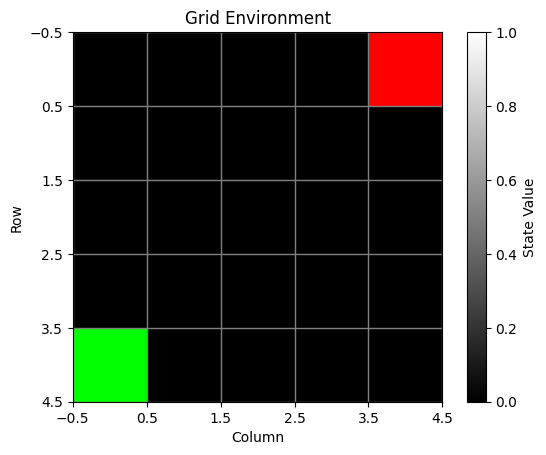

In [4]:
env_visualizer = envVisual.EnvironmentVisualizer(base_env)
env_visualizer.visualize()

In [ ]:
environment = base_env
agent_info = {"num_actions": 4, "num_states": 25, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent = QLearningAgent()
agent.agent_init(agent_info)

for i_episode in range(1):
    total_reward = 0.0
    num_steps = 1
    last_state = environment.env_start()
    last_action = agent.agent_start(last_state)
    observation = (last_state, last_action)
    while True:
        (reward, last_state, term) = environment.env_step(last_action)
        total_reward += reward

        env_visualizer.visualize()
        
        if term:
            agent.agent_end(reward)
            roat = (reward, last_state, None, term)
            print('End game! Reward: ', total_reward)
            break
        else:
            num_steps += 1
            last_action = agent.agent_step(reward, last_state)
            roat = (reward, last_state, last_action, term)

In [ ]:
environment = base_env
agent_info = {"num_actions": 4, "num_states": 25, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent = ExpectedSarsaAgent()
agent.agent_init(agent_info)

for i_episode in range(1):
    total_reward = 0.0
    num_steps = 1
    last_state = environment.env_start()
    last_action = agent.agent_start(last_state)
    observation = (last_state, last_action)
    while True:
        (reward, last_state, term) = environment.env_step(last_action)
        total_reward += reward

        env_visualizer.visualize()
        
        if term:
            agent.agent_end(reward)
            roat = (reward, last_state, None, term)
            print('End game! Reward: ', total_reward)
            break
        else:
            num_steps += 1
            last_action = agent.agent_step(reward, last_state)
            roat = (reward, last_state, last_action, term)

In [ ]:
agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}

env = gridworld_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 25, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 500 # The number of episodes in each run

for algorithm in ["Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(25)
#         last_episode_total_reward = 0
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(0)
            else:
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1

            reward_sums.append(rl_glue.rl_return())
#             last_episode_total_reward = rl_glue.rl_return()

        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

In [ ]:
for algorithm in ["Q-learning", "Expected Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,500)
plt.ylim(-100,0)
plt.legend()
plt.show()

In [ ]:
algorithms = ["Q-learning", "Expected Sarsa"]
num_algorithms = len(algorithms)

plt.figure(figsize=(12, 6))
for i, algo in enumerate(algorithms, start=1):
    plt.subplot(1, num_algorithms, i)
    average_state_visits = np.array(all_state_visits[algo][-10:]).mean(axis=0)
    title = f'State Visit Counts ({algo})'
    visualize_state_visits(average_state_visits, title)  # Use average_state_visits here instead of all_state_visits_for_algorithm[-1]

plt.tight_layout()
plt.show()